In [1]:
import numpy as np
import os
from my_rigid_kinematics import dh_robot_config
from JS_control import cacl_torque
import matplotlib.pyplot as plt
from pyrep import PyRep
from arm import CtRobot
from pyrep.backend import vrep
import sympy as sp
from pyrep.const import JointMode
%matplotlib notebook

pr = PyRep()

In [2]:
param = ['D', 'a', 'alpha', 'theta', 'num_joints', 'jointType', 'Tbase', 'L', 'M']
config = dict()
for i in range(len(param)):
    config[param[i]] = np.load('./robot_config/config1/%s.npy'%param[i])

In [3]:
robot = dh_robot_config(int(config['num_joints']), config['alpha'], config['theta'], config['D'], config['a'], 
                                                config['jointType'], config['Tbase'], config['L'], config['M'])
robot.initKinematicTransforms()

Calculating link 0
Calculating link 1
Calculating link 2
Calculating link 3
Calculating link 4
Calculating link 5
Calculating link 6
Calculating link 7
Calculating complete


## Simulation Set up

In [4]:
pr.launch(os.getcwd() + '/Modified_DH.ttt', headless=True)
ct_robot = CtRobot()

xyz = np.array([0, 0, 0])
err_pos = []
err_vel = []

for i in range(ct_robot._num_joints):
    ct_robot.joints[i].set_joint_mode(JointMode.FORCE)
    ct_robot.arms[i].set_dynamic(True)
    ct_robot.joints[i].set_control_loop_enabled(False)

In [5]:
pr.start()

In [6]:
dt = 0.01
end_time = 4
t_dic = np.linspace(0, end_time, num=int(end_time/dt), endpoint=True)
t = sp.Symbol('t')
# disired trajectory of position for each joint
traj = [
    0.005*sp.sin(t/2),
    0.006*sp.cos(t),
    (15/180*np.pi)*sp.sin(t),
    (6/180*np.pi)*sp.sin(t/2),
    (7/180*np.pi)*sp.cos(t/2),
    (8/180*np.pi)*sp.cos(t/2),
    0.002*sp.sin(t/2)+0.002
]
pos = [sp.lambdify(t, i) for i in traj]
vel = [sp.lambdify(t, i.diff(t)) for i in traj]
acc = [sp.lambdify(t, i.diff(t).diff(t)) for i in traj]

In [7]:
for i in range(int(end_time/dt)):
    posd = np.array([j(t_dic[i]) for j in pos])
    veld = np.array([j(t_dic[i]) for j in vel])
    accd = np.array([j(t_dic[i]) for j in acc])
    posm = np.array(ct_robot.get_joint_positions())
    velm = np.array(ct_robot.get_joint_velocities())
    tau = cacl_torque(robot, posd, posm, veld, velm, xyz)
    ct_robot.set_joint_forces(tau.tolist())
    ct_robot.set_joint_target_velocities(veld.tolist())
    pr.step()
    
    measure_pos = np.array(ct_robot.get_joint_positions())
    measure_vel = np.array(ct_robot.get_joint_velocities())
    
    err_pos.append(posd - measure_pos)
    err_vel.append(veld - measure_vel)

In [8]:
err_pos = np.array(err_pos)
err_pos[:, 0:1] = err_pos[:, 0:1]*1000
err_pos[:, 1:2] = err_pos[:, 1:2]*1000
err_pos[:, 6:7] = err_pos[:, 6:7]*1000
err_pos[:, 2:3] = err_pos[:, 2:3]*180/np.pi
err_pos[:, 3:4] = err_pos[:, 3:4]*180/np.pi
err_pos[:, 4:5] = err_pos[:, 4:5]*180/np.pi
err_pos[:, 5:6] = err_pos[:, 5:6]*180/np.pi

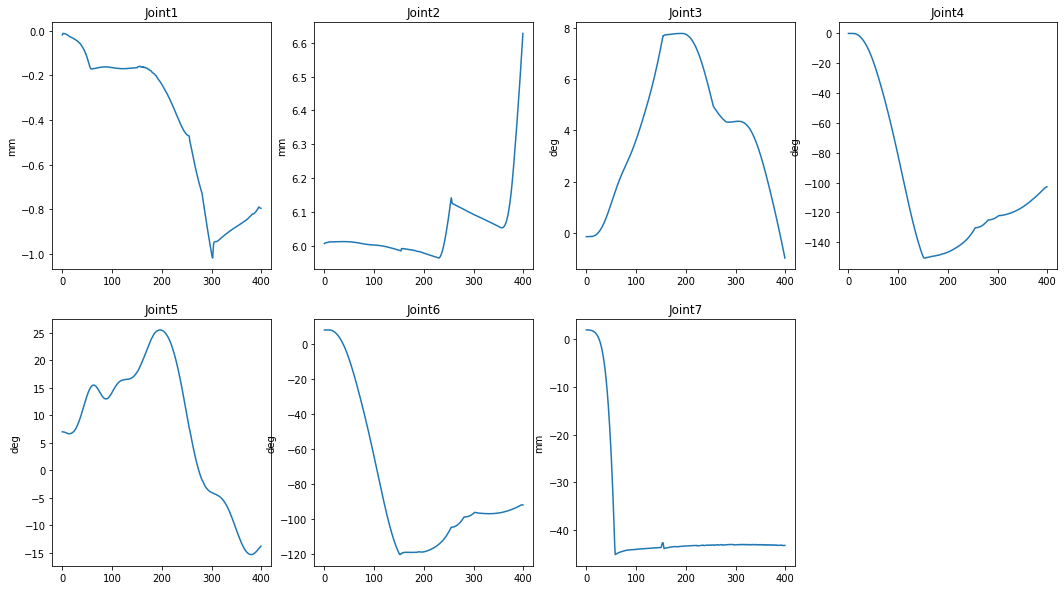

In [9]:
plt.figure(figsize=(18,10))
for i in range(7):
    plt.subplot(2,4,i+1)
    plt.title('Joint%d'%(i+1))
    plt.plot(np.array(err_pos)[:, i])
    if i in [0,1,6]:
        plt.ylabel('mm')
    else:
        plt.ylabel('deg')

In [10]:
pr.stop()

In [11]:
pr.shutdown()